# Dependencies and paths to datasets

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import seaborn as sns

yt_path = "../data/youtube_topics.csv"
gd_path = "../data/gdelt_topics.csv"

# Read datasets

In [43]:
yt = pd.read_csv(yt_path)
gd = pd.read_csv(gd_path)

# Aggregate YouTube sentiment weekly for future forecasting

In [9]:
yt["comment_published_at"] = pd.to_datetime(
    yt["comment_published_at"],
    errors="coerce" 
)

yt["week"] = yt["comment_published_at"].dt.to_period("W").dt.start_time

weekly_yt_overall = (
    yt.groupby("week")["sentiment_value"]
      .mean()
      .reset_index()
      .sort_values("week")
)

weekly_yt_overall.head()

/var/folders/x3/mw36__rx0135gz7pb76mlbcr0000gn/T/ipykernel_21523/2131582299.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  yt["week"] = yt["comment_published_at"].dt.to_period("W").dt.start_time


,week,sentiment_value
0,2022-03-07,0.0
1,2022-04-18,0.0
2,2022-05-02,0.0
3,2022-05-16,1.0
4,2022-05-30,1.0


# Forecast YouTube sentiment for next half a year

In [10]:
ts_yt_overall = weekly_yt_overall.rename(columns={"week": "ds", "sentiment_value": "y"})
ts_yt_overall.head()

m_yt_overall = Prophet()
m_yt_overall.fit(ts_yt_overall)

# Forecast horizon: next 26 weeks (6 months)
yt_forecast_horizon = 26
future_yt_overall = m_yt_overall.make_future_dataframe(
    periods=yt_forecast_horizon, freq="W"
)
forecast_yt_overall = m_yt_overall.predict(future_yt_overall)

forecast_yt_overall[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

17:57:47 - cmdstanpy - INFO - Chain [1] start processing
17:57:48 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
204,2026-05-10,-0.167947,-0.399211,0.059284
205,2026-05-17,-0.102748,-0.315513,0.132568
206,2026-05-24,-0.109731,-0.342545,0.106419
207,2026-05-31,-0.181506,-0.412350,0.045236
208,2026-06-07,-0.238211,-0.483911,-0.018776


# Build plots of YouTube observed weekly sentiment and forecast sentiment

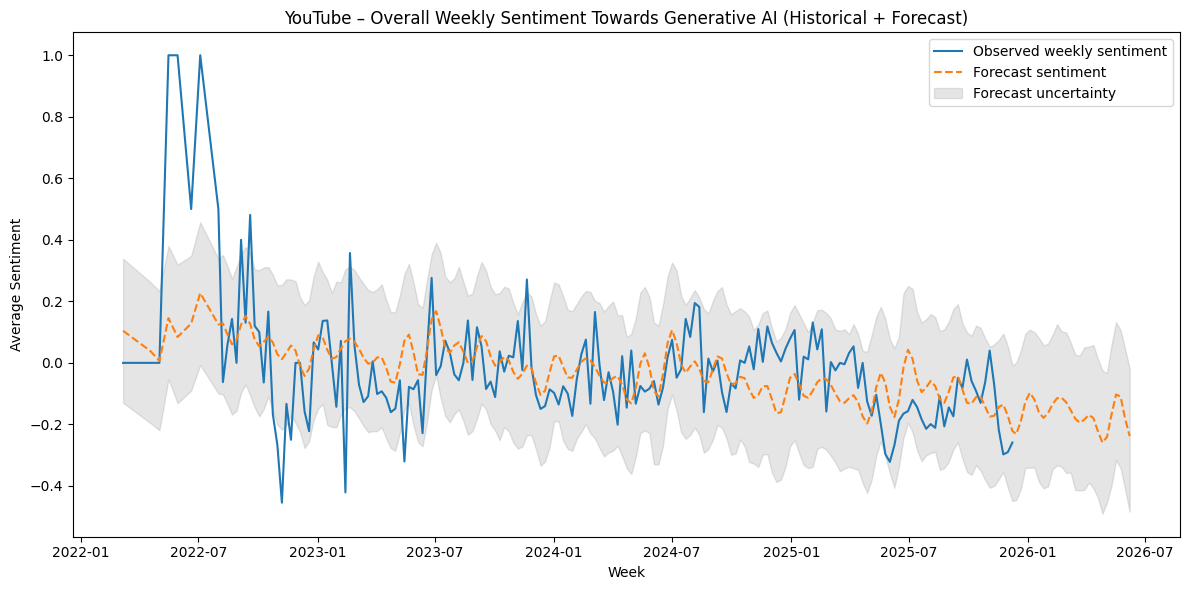

In [11]:
plt.figure(figsize=(12, 6))

# Historical
plt.plot(ts_yt_overall["ds"], ts_yt_overall["y"], label="Observed weekly sentiment")

# Forecast
plt.plot(forecast_yt_overall["ds"], forecast_yt_overall["yhat"],
         label="Forecast sentiment", linestyle="--")

# Uncertainty interval
plt.fill_between(
    forecast_yt_overall["ds"],
    forecast_yt_overall["yhat_lower"],
    forecast_yt_overall["yhat_upper"],
    color="gray",
    alpha=0.2,
    label="Forecast uncertainty"
)

plt.title("YouTube – Overall Weekly Sentiment Towards Generative AI (Historical + Forecast)")
plt.xlabel("Week")
plt.ylabel("Average Sentiment")
plt.legend()
plt.tight_layout()
plt.show()

# Aggregate YouTube sentiment weekly by macro category

In [13]:
weekly_yt_cat = (
    yt.groupby(["week", "macro_category"])["sentiment_value"]
        .mean()
        .reset_index()
        .sort_values(["macro_category", "week"])
)
weekly_yt_cat.head()



,week,macro_category,sentiment_value
0,2022-03-07,Other,0.0
3,2022-05-02,Other,0.0
6,2022-06-20,Other,0.5
7,2022-07-04,Other,1.0
8,2022-08-01,Other,1.0


# Functions for forecasting by macro categories 

In [16]:
def prepare_weekly_series_for_category(df, date_col="week", category_col="macro_category",
                                       value_col="sentiment_value", category_value=None):
    """Return a Prophet-ready df (ds, y) for a given macro_category."""
    if df is None or category_value is None:
        return None
    
    sub = df[df[category_col] == category_value].copy()

    weekly = (
        sub.groupby(date_col)[value_col]
           .mean()
           .reset_index()
           .sort_values(date_col)
           .rename(columns={date_col: "ds", value_col: "y"})
    )
    return weekly


def fit_and_forecast_prophet(ts_df, periods=26, freq="W"):
    """Fit Prophet on a (ds,y) df and forecast given number of periods."""
    m = Prophet()
    m.fit(ts_df)
    future = m.make_future_dataframe(periods=periods, freq=freq)
    forecast = m.predict(future)
    return m, forecast


# Build plots of observed and predicted YouTube weekly sentiment by macro category

18:47:00 - cmdstanpy - INFO - Chain [1] start processing
18:47:00 - cmdstanpy - INFO - Chain [1] done processing


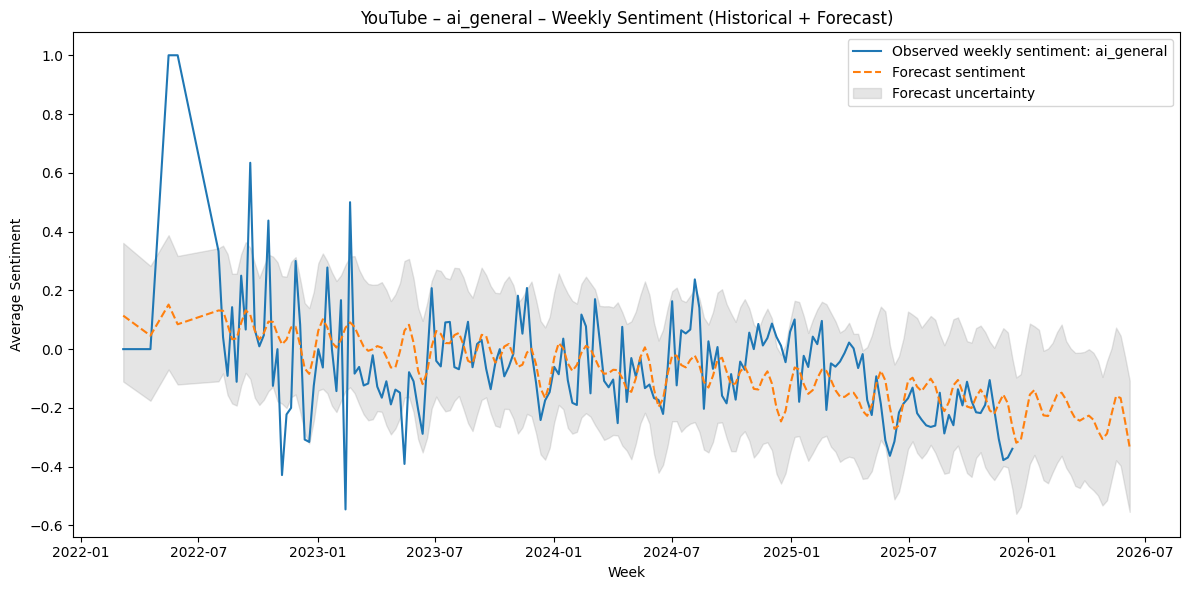

18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing


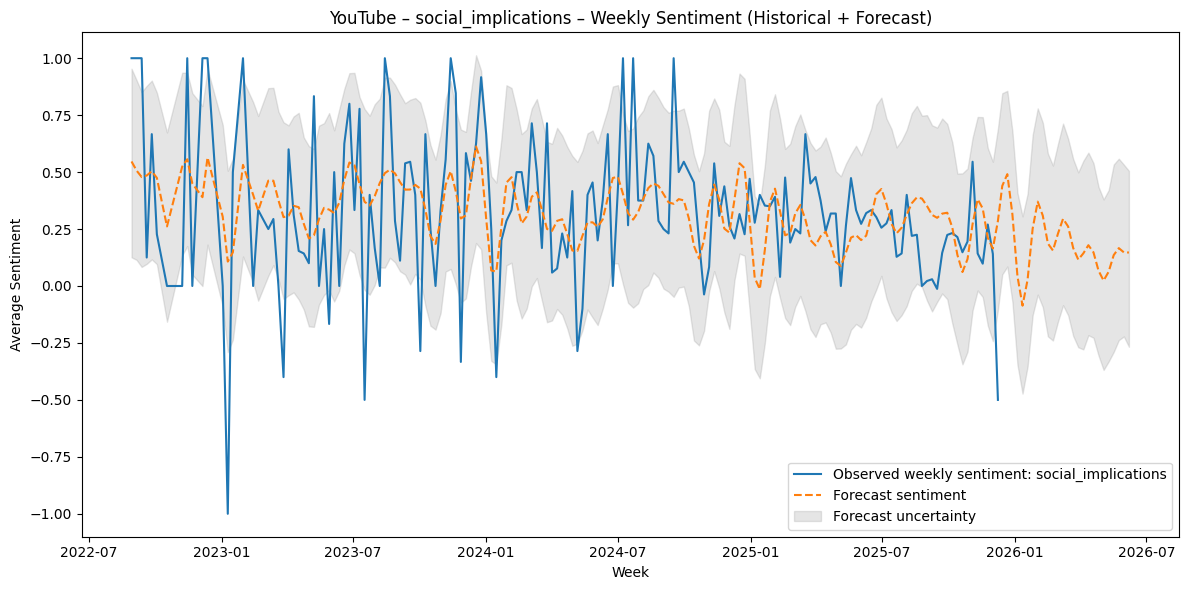

18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:01 - cmdstanpy - INFO - Chain [1] done processing


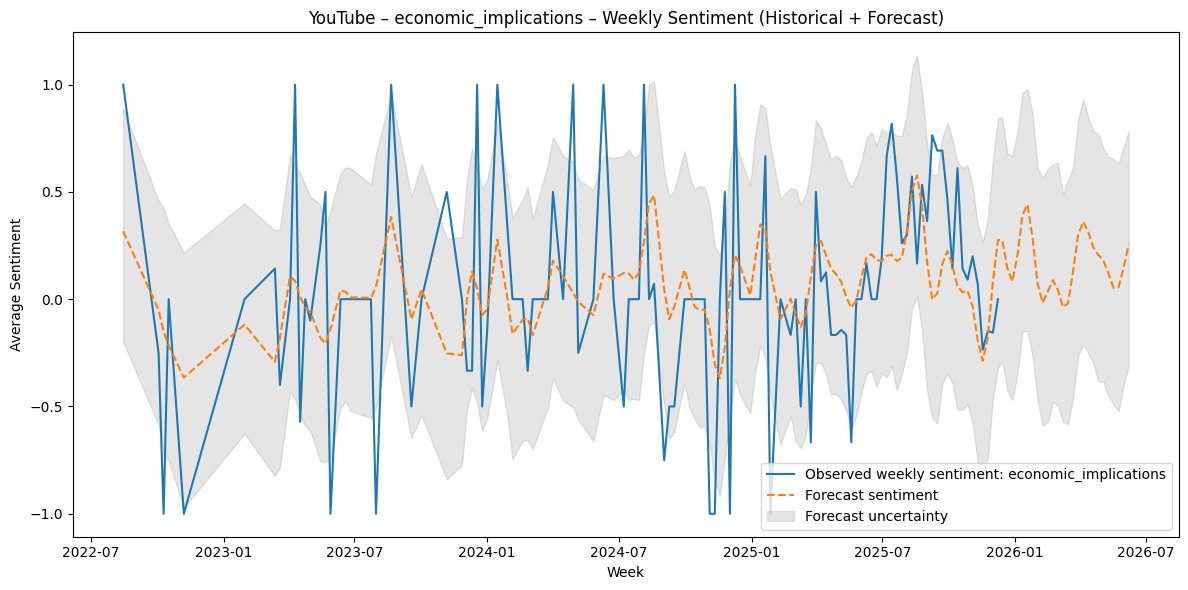

In [17]:
categories_to_forecast = [
        "ai_general",
        "social_implications",
        "economic_implications",
    ]

for cat in categories_to_forecast:
    ts_cat = prepare_weekly_series_for_category(
        weekly_yt_cat,
        date_col="week",
        category_col="macro_category",
        value_col="sentiment_value",
        category_value=cat,
    )
    if ts_cat is None:
        continue

    m_cat, forecast_cat = fit_and_forecast_prophet(ts_cat, periods=26, freq="W")

    plt.figure(figsize=(12, 6))
    plt.plot(ts_cat["ds"], ts_cat["y"], label=f"Observed weekly sentiment: {cat}")
    plt.plot(forecast_cat["ds"], forecast_cat["yhat"],
            label="Forecast sentiment", linestyle="--")
    plt.fill_between(
        forecast_cat["ds"],
        forecast_cat["yhat_lower"],
        forecast_cat["yhat_upper"],
        color="gray",
        alpha=0.2,
        label="Forecast uncertainty"
    )
    plt.title(f"YouTube – {cat} – Weekly Sentiment (Historical + Forecast)")
    plt.xlabel("Week")
    plt.ylabel("Average Sentiment")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Aggregate GDELt sentiment weekly for future forecasting

In [31]:
gd["published_at_dt"] = pd.to_datetime(
    gd["published_at_dt"],
    errors="coerce"   # invalid values → NaT
)

gd["week"] = gd["published_at_dt"].dt.to_period("W").dt.start_time

weekly_gd_overall = (
    gd.groupby("week")["sentiment_value"]
      .mean()
      .reset_index()
      .sort_values("week")
)

ts_gd_overall = weekly_gd_overall.rename(columns={"week": "ds", "sentiment_value": "y"})
ts_gd_overall.head()

/var/folders/x3/mw36__rx0135gz7pb76mlbcr0000gn/T/ipykernel_21523/2832658210.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  gd["week"] = gd["published_at_dt"].dt.to_period("W").dt.start_time


,ds,y
0,2021-12-27,0.333333
1,2022-01-03,0.043478
2,2022-01-10,0.119403
3,2022-01-17,0.101695
4,2022-01-24,0.054795


# Forecast GDELT sentiment for next half a year

In [32]:
m_gd_overall = Prophet()
m_gd_overall.fit(ts_gd_overall)

gd_forecast_horizon = 26  # weeks
future_gd_overall = m_gd_overall.make_future_dataframe(
    periods=gd_forecast_horizon, freq="W"
)
forecast_gd_overall = m_gd_overall.predict(future_gd_overall)

forecast_gd_overall[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


19:32:49 - cmdstanpy - INFO - Chain [1] start processing
19:32:49 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
226,2026-05-10,-0.030814,-0.109492,0.042770
227,2026-05-17,0.004737,-0.073586,0.077804
228,2026-05-24,0.013139,-0.059572,0.085767
229,2026-05-31,-0.018405,-0.094398,0.057200
230,2026-06-07,-0.057933,-0.141748,0.016207


# Build plots of GDELT observed weekly sentiment and forecast sentiment

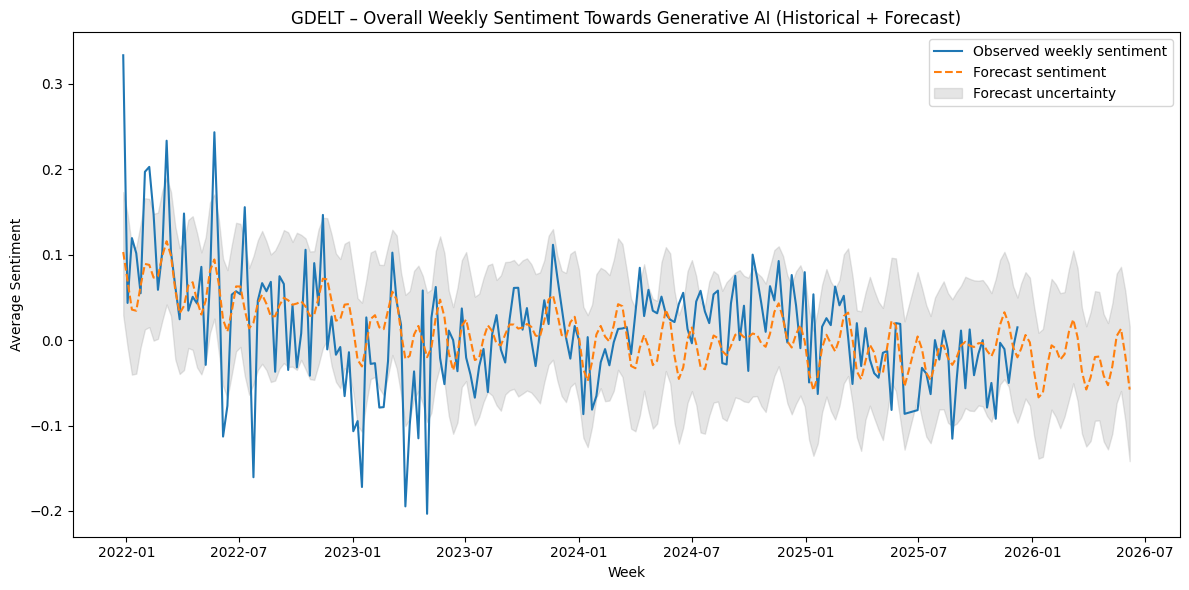

In [33]:
plt.figure(figsize=(12, 6))

plt.plot(ts_gd_overall["ds"], ts_gd_overall["y"], label="Observed weekly sentiment")
plt.plot(forecast_gd_overall["ds"], forecast_gd_overall["yhat"],
         label="Forecast sentiment", linestyle="--")
plt.fill_between(
    forecast_gd_overall["ds"],
    forecast_gd_overall["yhat_lower"],
    forecast_gd_overall["yhat_upper"],
    color="gray",
    alpha=0.2,
    label="Forecast uncertainty"
)

plt.title("GDELT – Overall Weekly Sentiment Towards Generative AI (Historical + Forecast)")
plt.xlabel("Week")
plt.ylabel("Average Sentiment")
plt.legend()
plt.tight_layout()
plt.show()


# Forecasting by macro categories 

In [34]:
weekly_gd_cat = (
        gd.groupby(["week", "macro_category"])["sentiment_value"]
          .mean()
          .reset_index()
          .sort_values(["macro_category", "week"])
    )

# Build plots of observed and predicted YouTube weekly sentiment by macro category

19:35:52 - cmdstanpy - INFO - Chain [1] start processing
19:35:52 - cmdstanpy - INFO - Chain [1] done processing


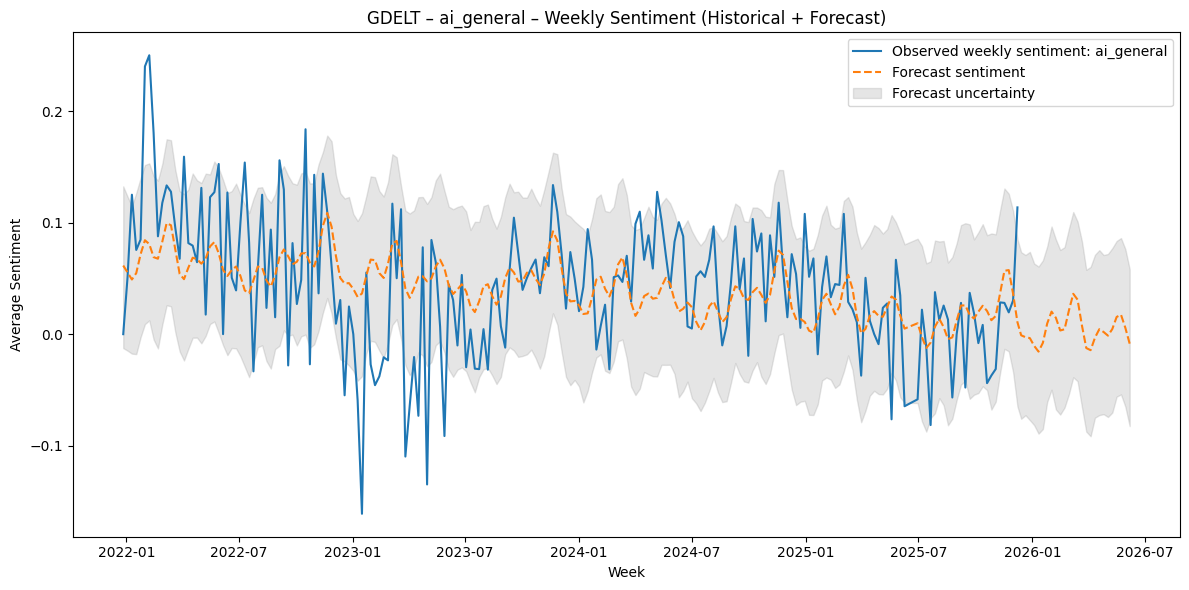

19:35:53 - cmdstanpy - INFO - Chain [1] start processing
19:35:53 - cmdstanpy - INFO - Chain [1] done processing


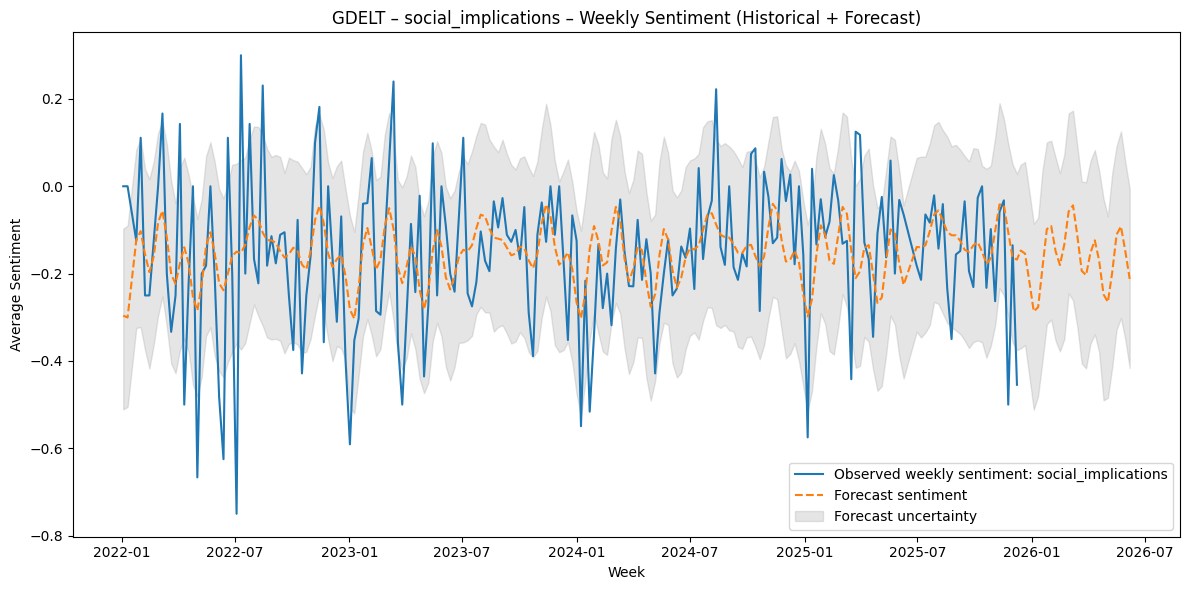

19:35:53 - cmdstanpy - INFO - Chain [1] start processing
19:35:53 - cmdstanpy - INFO - Chain [1] done processing


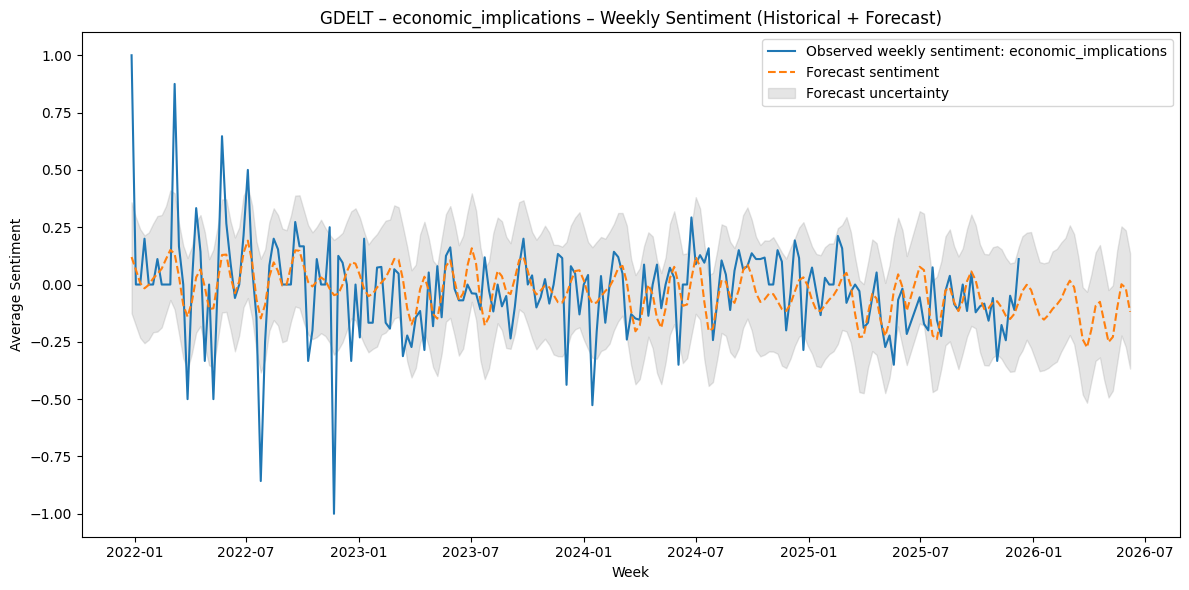

In [36]:
categories_to_forecast_gd = [
        "ai_general",
        "social_implications",
        "economic_implications",
    ]

for cat in categories_to_forecast_gd:
    ts_cat = prepare_weekly_series_for_category(
        weekly_gd_cat,
        date_col="week",
        category_col="macro_category",
        value_col="sentiment_value",
        category_value=cat,
    )
    if ts_cat is None:
            continue

    m_cat, forecast_cat = fit_and_forecast_prophet(ts_cat, periods=26, freq="W")

    plt.figure(figsize=(12, 6))
    plt.plot(ts_cat["ds"], ts_cat["y"], label=f"Observed weekly sentiment: {cat}")
    plt.plot(forecast_cat["ds"], forecast_cat["yhat"],
            label="Forecast sentiment", linestyle="--")
    plt.fill_between(
        forecast_cat["ds"],
        forecast_cat["yhat_lower"],
        forecast_cat["yhat_upper"],
        color="gray",
        alpha=0.2,
        label="Forecast uncertainty"
    )
    plt.title(f"GDELT – {cat} – Weekly Sentiment (Historical + Forecast)")
    plt.xlabel("Week")
    plt.ylabel("Average Sentiment")
    plt.legend()
    plt.tight_layout()
    plt.show()